In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
from mlp_helper import get_dataset, get_dataset_2

In [9]:
import numpy as np
from lab_helper import plot_boundaries, plot_boundaries_keras
from sklearn.metrics import roc_auc_score, roc_curve
from matplotlib import pyplot as plt
from PlotCallback import PlotCallback
from multiclass_helper import draw_neural_net
from keras import backend as K
import tensorflow as tf


In [10]:
def generate_gaussians_distributions(sep=1, N=500, random_state=42, normalize=True):
    np.random.seed(random_state)
    # Zeros
    X1 = np.random.multivariate_normal(sep*np.array([0.5, 0.5]), [[0.1,-0.085],[-0.085,0.1]], N//2)
    # Ones
    X2 = np.random.multivariate_normal([-0.25, -0.25], [[0.1,0],[0,0.1]], N//2)
    X = np.append(X1, X2, axis=0)
    y = np.append(np.zeros(N//2), np.ones(N//2))
    indexes = np.arange(len(y))
    np.random.shuffle(indexes)
    if normalize:
        X = (X - X.mean(axis=0))/X.std(axis=0)
    else:
        X[:, 0] = X[:, 0]
        X[:, 1] = X[:, 1]
    return X[indexes], y[indexes]

In [66]:
# Primero probar con N = 3000 para ver bien las distribuciones
X, y = generate_gaussians_distributions(sep=2, N = 500, normalize=False, random_state=41)

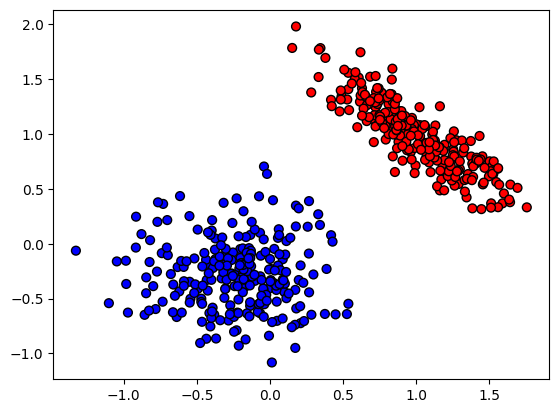

In [45]:
plot_boundaries(X,y)
plt.show()

In [46]:
# Solucion con sklearn
from sklearn.linear_model import LogisticRegression

In [124]:
lr_clf = LogisticRegression(
    penalty='l1',
    C=0.1,
    solver='liblinear'
)

In [125]:
lr_clf.fit(X, y)

LogisticRegression(C=0.1, penalty='l1', solver='liblinear')

In [126]:
lr_clf.coef_, lr_clf.intercept_

(array([[-2.46926307, -2.51689626]]), array([1.67932633]))

In [50]:
lr_clf.score(X, y)

1.0

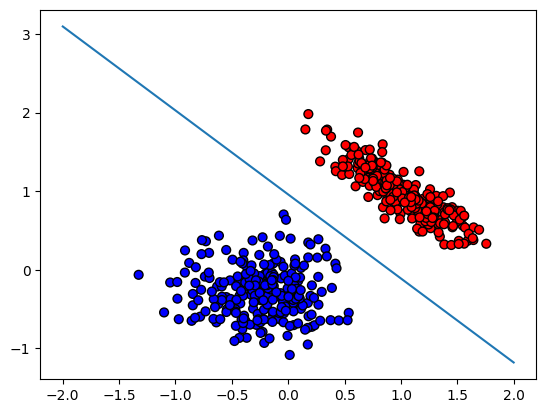

In [52]:
plot_boundaries(X,y)
X1 = np.linspace(-2, 2, 100)
X2  = (- lr_clf.coef_[0][0] * X1 - lr_clf.intercept_[0])/lr_clf.coef_[0][1]
plt.plot(X1, X2)
plt.show()

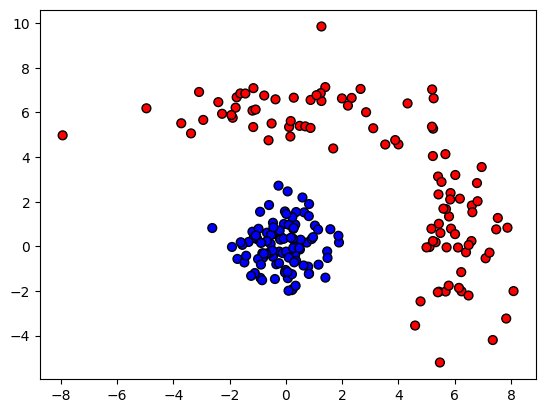

In [128]:
hidden_units = 2
if hidden_units==2:
    X, y = get_dataset(random_seed=42)
else:
    X, y = get_dataset_2()
plot_boundaries(X, y)
plt.show()

In [39]:
X_t, y_t = get_dataset(random_seed=4)
plot_boundaries(X_t, y_t)

# Armo modelo

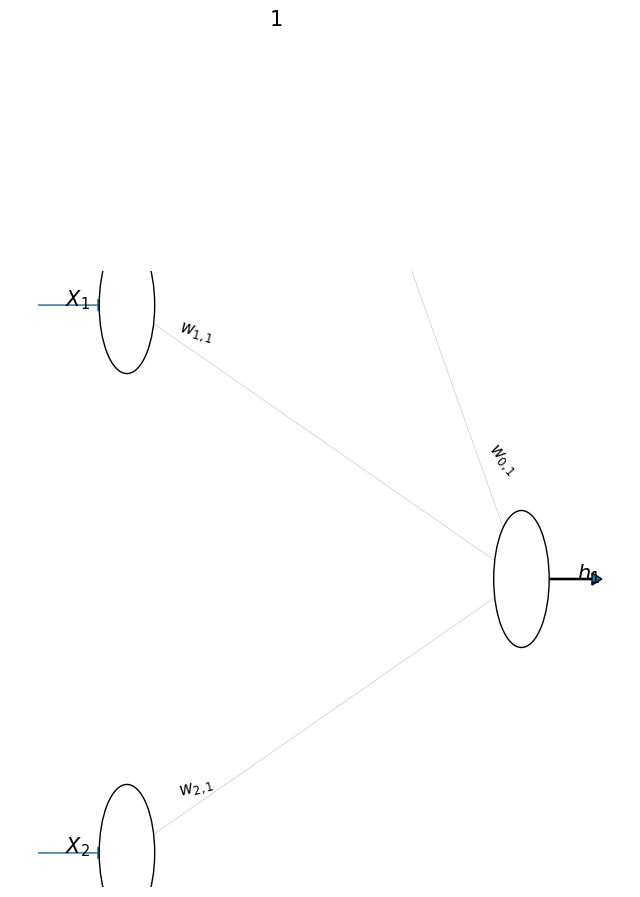

In [53]:
fig, ax = plt.subplots(1,1,figsize=(8, 8))
biases = [['$w_{0,1}$']]
capa_1 = [['$w_{1,1}$'],
          ['$w_{2,1}$']]
weights = [np.array(capa_1), [['1']]]
draw_neural_net(ax, 0.1, 0.9, 0, 0.9, [2,1], weights, biases)
plt.show()

# Pruebas a realizar:
- Ver situaciones particulares de inicialización: initial_weights_almost_right, initial_weights_inverted, initial_weights_cut_half
- Sin normalizar, lr=0.01, bins=30, sep=2, N=500
- Subir lr para acelerarlo
- Inicialización aleatoria, initial_weights_inverted.hdf5, initial_weights_cut_half.hdf5
- Normalizando,  lr=0.01, bins=30, sep=2,  N=500
- lr=0.01 hasta 10, hablar sobre cyclic learning rate
- ADAM con lr 10 llega a loss = 0 rapidamente
- ADAM con lr 2 llega a loss = 0 rapidamente despues de 40 epochs
- sep=1, lr = 1, batch_size=1, cambiarlo a batch_size=100 y comparar (Al final del entrenamiento)

In [129]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD, Adam

In [130]:
# model = Sequential()
# # Que pasa si no pongo la función de activación??!
# model.add(Dense(1, input_shape=(2,), activation='sigmoid'))

In [131]:
X.shape

(200, 2)

In [132]:
input_dim = X.shape[1]
activation = 'sigmoid'
model = Sequential()
# model.add(Dense(hidden_units, input_shape=(input_dim,), activation=activation))
model.add(
    Dense(
        1,
        input_shape=(input_dim,),
        activation='sigmoid'
    )
)
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 1)                 3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


In [133]:
# model.save_weights('initial_weights_almost_right.hdf5')

In [134]:
# model.load_weights('initial_weights_almost_right.hdf5')
# model.load_weights('initial_weights_inverted.hdf5')
# model.load_weights('initial_weights_cut_half.hdf5')

model.compile(Adam(lr=0.01), loss='binary_crossentropy', metrics=['accuracy'])

/Users/julian/opt/anaconda3/envs/RL/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [135]:
from keras.callbacks import Callback

In [136]:
class TensorBoardImage(Callback):
    def __init__(self, tag):
        super().__init__() 
        self.tag = tag

    def on_epoch_end(self, epoch, logs={}):
        # Load image
        img = data.astronaut()
        # Do something to the image
        img = (255 * skimage.util.random_noise(img)).astype('uint8')

        image = make_image(img)
        summary = tf.Summary(value=[tf.Summary.Value(tag=self.tag, image=image)])
        writer = tf.summary.FileWriter('./logs')
        writer.add_summary(summary, epoch)
        writer.close()

        return

In [137]:
from TensorboardMPLCallback import PlotCallbackTB

In [138]:
tbMLPCallback = PlotCallbackTB(X, y, bins=30)


In [69]:
len(X)

500

In [139]:
batch_size = 10
epochs = 20
iteraciones = epochs * (len(X) / batch_size)
iteraciones

400.0

In [140]:
len(X) / batch_size

20.0

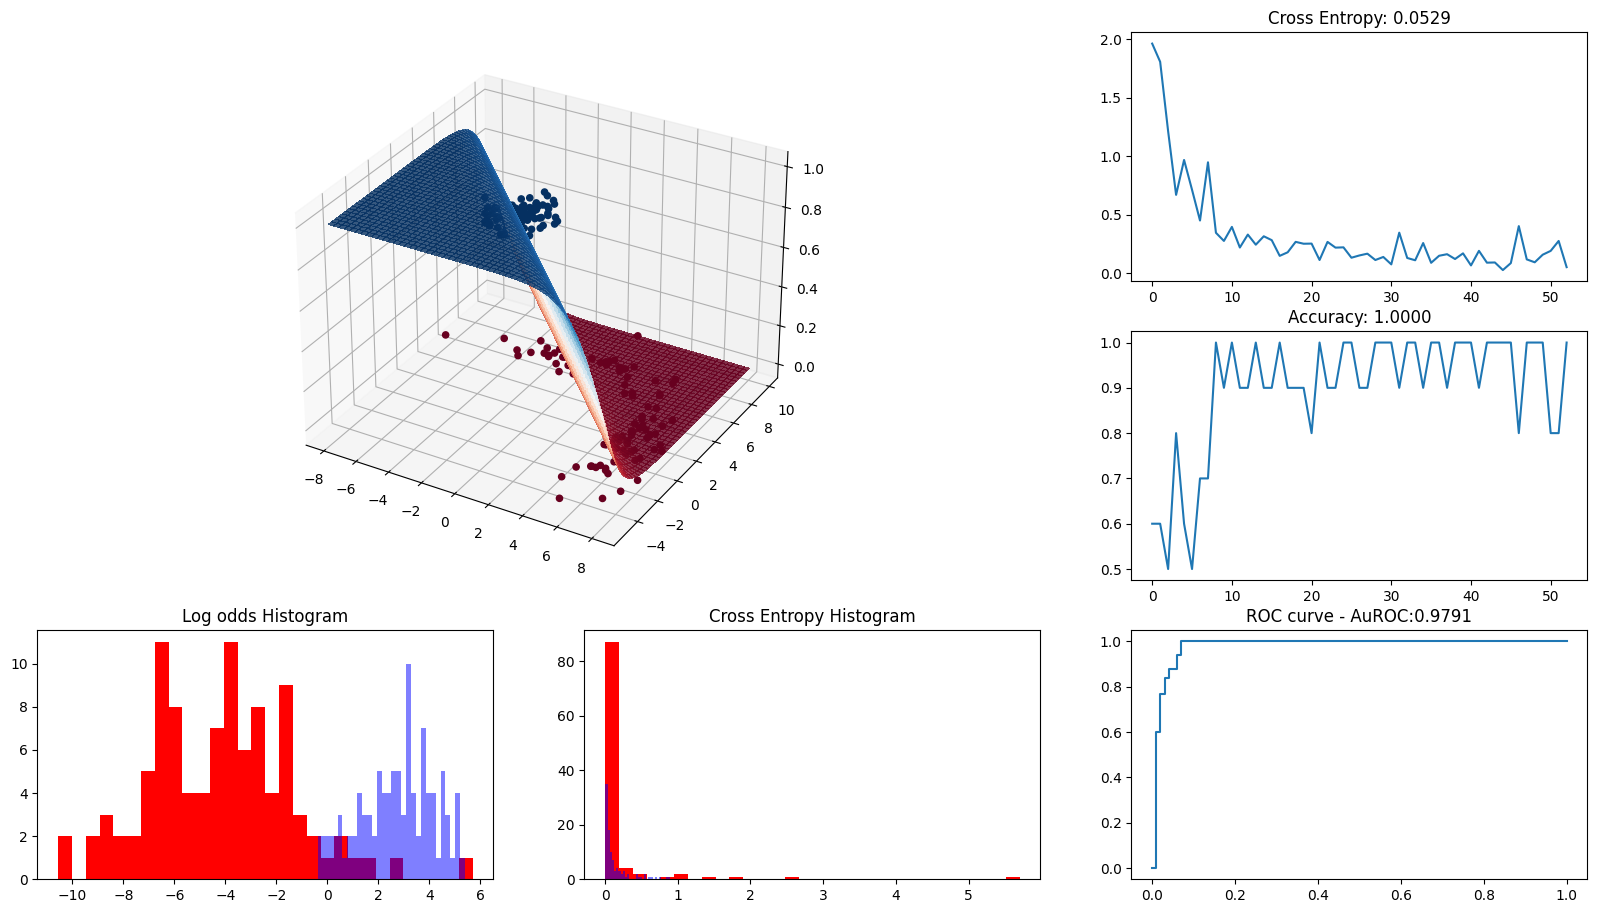

20/20 [==============================] - 3s 176ms/step - loss: 0.1692 - accuracy: 0.9450
Epoch 54/100
 1/20 [>.............................] - ETA: 0s - loss: 0.6336 - accuracy: 0.9000{'loss': 0.6335932016372681, 'accuracy': 0.8999999761581421}


In [141]:
# Arrancar con lr = 0.01, bs=128
# K.set_value(model.optimizer.lr, 0.1)
# Probar distintos tipos de verbose
# plotCallback = PlotCallback(X, y, bins=30)
tbMLPCallback = PlotCallbackTB(X, y, bins=30, plots_every_batches=500.0)
model.fit(
    X, y, epochs=100, callbacks=[tbMLPCallback], verbose=1, batch_size=batch_size, shuffle=True
)
# model.fit(X, y, epochs=2000, verbose=1, batch_size=128)

$log\_odds = \log(\large \frac{p_i}{1-p_i})$

$CE = - [y_i log(p_i) + (1-y_i) log(1-p_i)]$

In [92]:
# 400, 0,  11
i = 11
print(X[i:i+1][0], y[i])
p = model.predict(X[i:i+1])[0][0]
print(p)


[ 0.0192967  -0.38217853] 1.0
0.93363833


In [90]:
print(f'probabilidad: {p}')
print(f'log_odds: {np.log(p/(1-p))}')
print(f'cross_entropy: {-y[i]*np.log(p) - (1-y[i])*np.log(1-p)}')

probabilidad: 0.933638334274292
log_odds: 2.6439695744754412
cross_entropy: 0.06866613775491714


In [ ]:
f, ax = plt.subplots(1, 1)
plot_boundaries_keras(X, y, None, model.predict, ax=ax)
ax.scatter(X[i][0], X[i][1], s=100, color='w')

# Que parámetros aprendió el modelo?

In [99]:
model.get_weights()

[array([[-2.6974418],
        [-3.5178165]], dtype=float32),
 array([2.4158485], dtype=float32)]

In [95]:
coefs_, intercept_ = model.get_weights()

In [96]:
coefs_

array([[-1.8541719],
       [-2.789659 ]], dtype=float32)

In [97]:
intercept_

array([1.6136009], dtype=float32)

# Probabilidad de observación

In [45]:
observ = np.array([[0.5, 1]])
print(observ)

[[0.5 1. ]]


In [47]:
model.predict(observ)

array([[0.47547412]], dtype=float32)

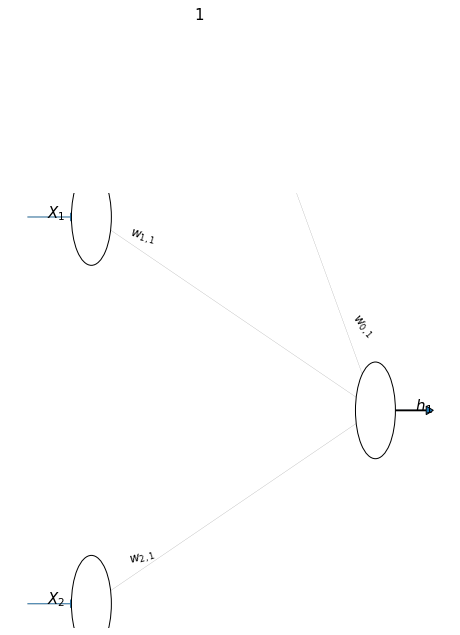

In [48]:
fig, ax = plt.subplots(1,1,figsize=(8, 8))
biases = [['$w_{0,1}$']]
capa_1 = [['$w_{1,1}$'],
          ['$w_{2,1}$']]
weights = [np.array(capa_1), [['1']]]
draw_neural_net(ax, 0.1, 0.9, 0, 0.9, [2,1], weights, biases)
plt.show()

In [49]:
h1 = observ.dot(coefs_) + intercept_
print(h1)

[[-0.0981823]]


In [50]:
p_ = 1/(1+np.exp(-h1))
print(p_)

[[0.47547412]]


# Cálculo de loss y accuracy

In [51]:
y_true = 1
model.evaluate([[0.5, 1]], [y_true])

1/1 [==============================] - 0s 81ms/step - loss: 0.7434 - accuracy: 0.0000e+00


[0.7434428334236145, 0.0]

In [52]:
y_true*np.log(1/(p_)) + (1-y_true)*np.log(1/(1-p_))

array([[0.74344282]])

In [53]:
np.log10(0.85144224)

-0.06984480830044822